In [117]:
import nibabel as nib
import matplotlib.pyplot as plt
from matplotlib import patches
import numpy as np
import re
import os
import cv2
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import albumentations as augm
from albumentations.pytorch import ToTensorV2
import sklearn
from scipy.optimize import curve_fit
import json

In [14]:
def load_nifti_image(file_path):
    img = nib.load(file_path)
    img_data = img.get_fdata()
    return img_data

# Site 1

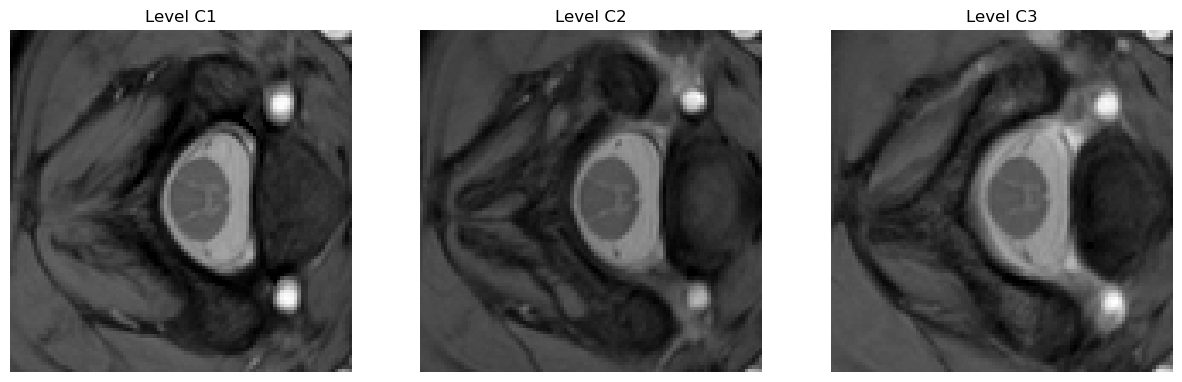

In [15]:
img_test = load_nifti_image('./train/site1-sc01-image.nii.gz')
plt.figure(figsize=(15,6))
for k in range(3):
    plt.subplot(1,3,k+1)
    plt.imshow(img_test[:,:,k], cmap='gray')
    plt.axis('off')
    plt.title(f'Level C{k+1}')

Site 2

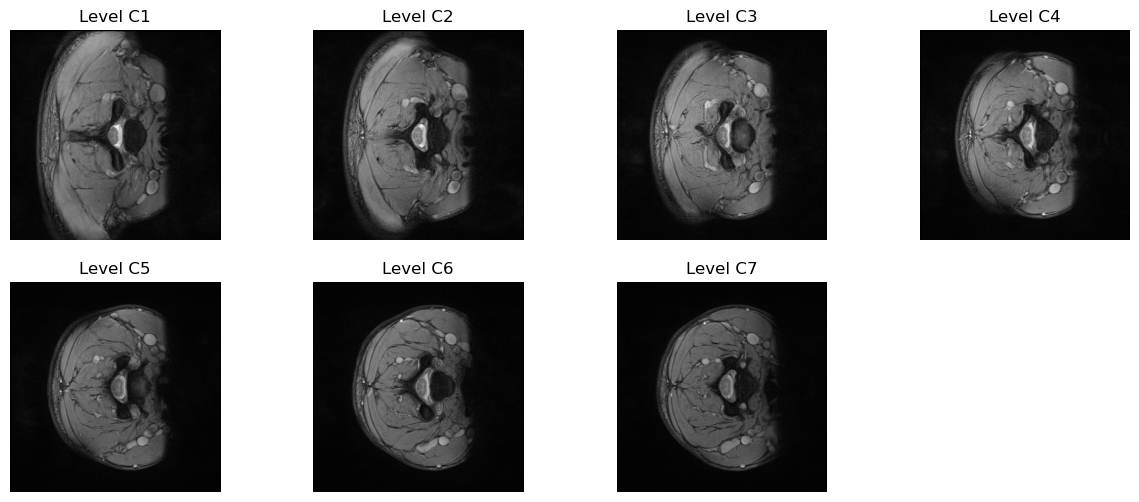

In [16]:
img_test = load_nifti_image('./train/site2-sc06-image.nii.gz')
plt.figure(figsize=(15,6))
for k in range(7):
    plt.subplot(2,4,k+1)
    plt.imshow(img_test[:,:,k], cmap='gray')
    plt.axis('off')
    plt.title(f'Level C{k+1}')

Site 3

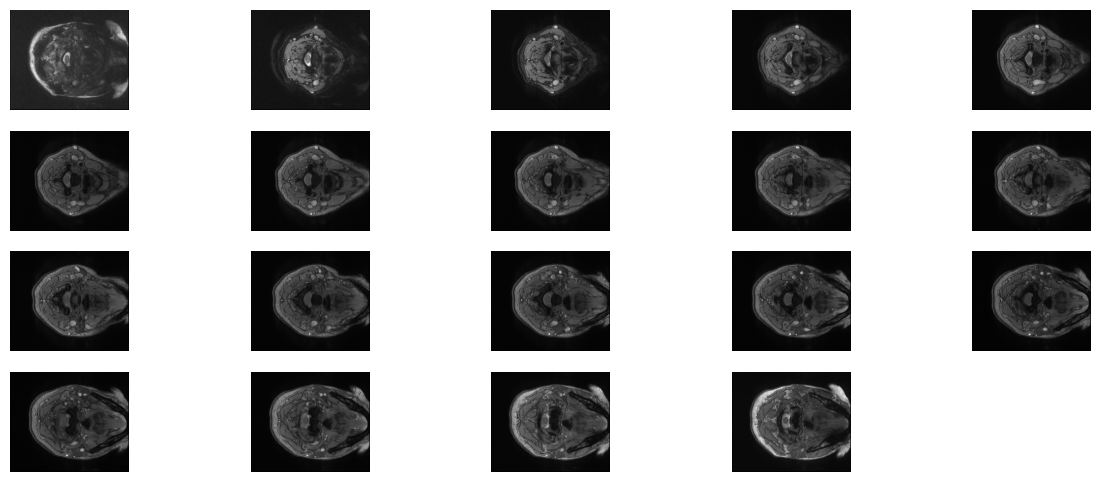

In [17]:
img_test = load_nifti_image('./train/site3-sc01-image.nii.gz')
img_test.shape
plt.figure(figsize=(15,6))
for k in range(4,23):
    plt.subplot(4,5,k-3)
    plt.imshow(img_test[:,:,k], cmap='gray')
    plt.axis('off')

Site 4

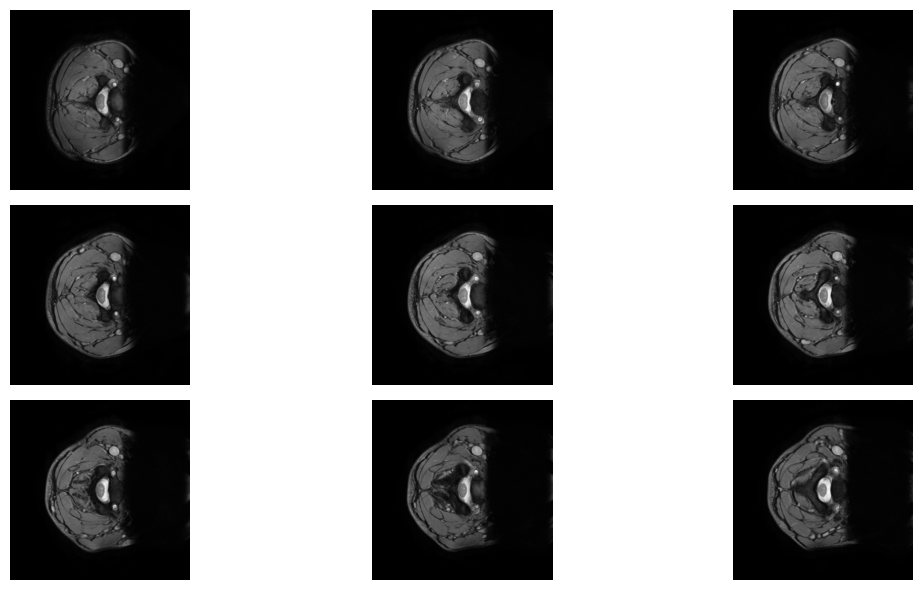

In [18]:
img_test = load_nifti_image('./train/site4-sc02-image.nii.gz')
img_test.shape
plt.figure(figsize=(15,6))
for k in range(3,12):
    plt.subplot(3,3,k-2)
    plt.imshow(img_test[:,:,k], cmap='gray')
    plt.axis('off')
    plt.tight_layout()

In [19]:
def binarize(mask):
    binarized_mask = np.zeros(mask.shape)
    for x in range(mask.shape[0]):
        for y in range(mask.shape[1]):
            if mask[x,y] == 1:
                binarized_mask[x,y] = 1
            else:
                pass
    return binarized_mask

def extract_mask_extrema(binary_mask):
    indices = np.argwhere(binary_mask == 1)
    xmin = np.min(indices[:,1])
    xmax = np.max(indices[:,1])
    ymin = np.max(indices[:,0])
    ymax = np.min(indices[:,0])
    return (xmin, xmax-xmin, ymax, ymin-ymax)

In [20]:
def crop_image_around_the_mask(img, binary_mask, SIZE_SQUARE=100, max_shift=30):
    (x, w, y, h) = extract_mask_extrema(binary_mask)
    width_to_add = round((SIZE_SQUARE - w) / 2)
    height_to_add = round((SIZE_SQUARE - h) / 2)

    shift_x = np.random.randint(-max_shift, max_shift)
    shift_y = np.random.randint(-max_shift, max_shift)

    y_min = max(0, y - height_to_add + shift_y)
    y_max = min(img.shape[0], y + height_to_add + h + shift_y)
    x_min = max(0, x - width_to_add + shift_x)
    x_max = min(img.shape[1], x + width_to_add + w + shift_x)
    if (y_max - y_min) != SIZE_SQUARE:
        if y_min == 0:
            y_max = SIZE_SQUARE
        else:
            y_min = y_max - SIZE_SQUARE
    if (x_max - x_min) != SIZE_SQUARE:
        if x_min == 0:
            x_max = SIZE_SQUARE
        else:
            x_min = x_max - SIZE_SQUARE

    cropped_img = img[y_min:y_max, x_min:x_max]
    cropped_mask = binary_mask[y_min:y_max, x_min:x_max]
    return cropped_img, cropped_mask


(-0.5, 99.5, 99.5, -0.5)

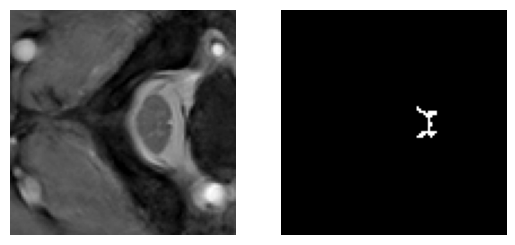

In [21]:
img_test_bis = load_nifti_image('./train/site1-sc02-image.nii.gz')[:,:,2]
mask_test_bis = load_nifti_image('./train/site1-sc02-mask-r1.nii.gz')[:,:,2]
cropped_img, cropped_mask = crop_image_around_the_mask(img_test_bis, binarize(mask_test_bis), SIZE_SQUARE=500, max_shift=1)
plt.subplot(1,2,1)
plt.imshow(cropped_img, cmap='gray')
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(cropped_mask, cmap='gray')
plt.axis('off')

In [22]:
def get_levels(filename):
    list_levels = []
    with open(filename, 'r') as file:
        lines = file.readlines()
    for line in lines[1:]:
        try:
            levels_in_file = re.findall('(,)(.*)', line)[0][1]
            list_levels.append(int(levels_in_file.strip()[0]))
        except:
            list_levels.append(None)
    return list_levels

In [23]:
dict_filepaths={}
filename_img = []
filename_levels = []
filename_masks = []
for site_index in range(1,5):
    for irm_index in range(1,11):
        if irm_index < 10:
            name_index = '0' + str(irm_index)
        else:
            name_index = '10'
        filename_img.append('./train/site'+str(site_index)+'-sc'+name_index+'-image.nii.gz')
        filename_levels.append('./train/site'+str(site_index)+'-sc'+name_index+'-levels.txt')
        filename_masks.append(['./train/site'+str(site_index)+'-sc'+name_index+'-mask-r'+str(i)+'.nii.gz' for i in range(1,5)])

In [24]:
for k in range(len(filename_img)):
    dict_filepaths['MRI'+str(k)]={
            'site' : int(filename_img[k][12:13]),
            'filename_img' : filename_img[k],
            'filename_levels' : filename_levels[k],
            'filename_masks' : filename_masks[k]
    }

In [25]:
dict_filepaths['MRI0']

{'site': 1,
 'filename_img': './train/site1-sc01-image.nii.gz',
 'filename_levels': './train/site1-sc01-levels.txt',
 'filename_masks': ['./train/site1-sc01-mask-r1.nii.gz',
  './train/site1-sc01-mask-r2.nii.gz',
  './train/site1-sc01-mask-r3.nii.gz',
  './train/site1-sc01-mask-r4.nii.gz']}

In [26]:
def majoritary_mask(masks_paths):
    mask1 = load_nifti_image(masks_paths[0])
    mask2 = load_nifti_image(masks_paths[1])
    mask3 = load_nifti_image(masks_paths[2])
    mask4 = load_nifti_image(masks_paths[3])
    mask_majoritary_vote = []
    for slice in range(mask1.shape[2]):
        binary_slice_mask1 = binarize(mask1[:,:,slice])
        binary_slice_mask2 = binarize(mask2[:,:,slice])
        binary_slice_mask3 = binarize(mask3[:,:,slice])
        binary_slice_mask4 = binarize(mask4[:,:,slice])
        sum_binary_slice = binary_slice_mask1 + binary_slice_mask2 + binary_slice_mask3 + binary_slice_mask4
        binary_slice = (sum_binary_slice>2).astype('uint8')
        mask_majoritary_vote.append(binary_slice)
    return np.moveaxis(np.array(mask_majoritary_vote), 0, -1)

In [27]:
def display_image_and_its_mask(img, mask):
    img_normalized = np.copy(img) / np.max(img)
    img_with_mask = np.copy(img_normalized)
    for x in range(img.shape[0]):
        for y in range(img.shape[1]):
            if mask[x,y]==1:
                img_with_mask[x,y]=1
            else:
                pass
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.imshow(img_normalized, cmap='gray')
    plt.axis('off')
    plt.title('Base image')

    plt.subplot(1,2,2)
    plt.imshow(img_with_mask, cmap='gray')
    plt.axis('off')
    plt.title('Image with mask')

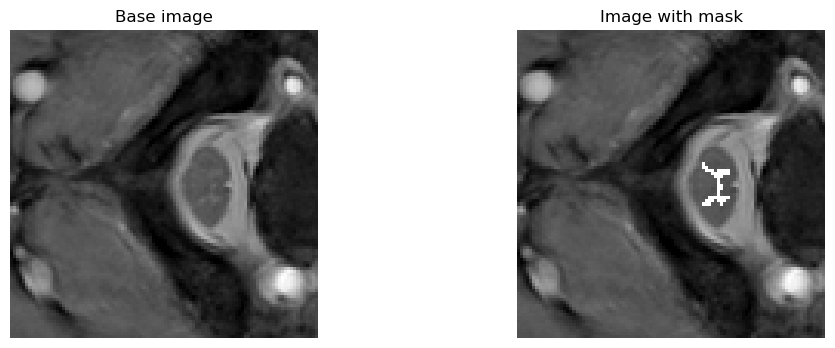

In [28]:
display_image_and_its_mask(cropped_img, cropped_mask)

In [29]:
def remove_null_image(mri, mask, levels):
    (x,y,_) = mri.shape
    levels_without_none = []
    mri_without_null = []
    mask_without_null = []
    for i in range(len(levels)):
        if levels[i] is None or np.array_equal(mask[:,:,i], np.zeros((x,y))):
            pass
        else:
            levels_without_none.append(levels[i])
            mri_without_null.append(mri[:,:,i])
            mask_without_null.append(mask[:,:,i])
    return np.moveaxis(np.array(mri_without_null), 0, -1), np.moveaxis(np.array(mask_without_null), 0, -1), levels_without_none

In [30]:
def load_mri_slices(dict_filepaths, MRI_index):
    name_mri = 'MRI'+str(MRI_index)
    mri = load_nifti_image(dict_filepaths[name_mri]['filename_img'])
    levels = get_levels(dict_filepaths[name_mri]['filename_levels'])
    mask = majoritary_mask(dict_filepaths[name_mri]['filename_masks'])
    mri_formated, mask_formated, levels_formated = remove_null_image(mri, mask, levels)
    return mri_formated, mask_formated, levels_formated

In [31]:
MRI_SLICES_PATH = './data_formated/MRI_slices/'
MASK_SLICES_PATH = './data_formated/masks_slices/'
def save_slice_as_single_file(dict_filepaths, index, filepath_slices_mri = MRI_SLICES_PATH, filepath_slices_masks = MASK_SLICES_PATH):
    cropping_factors = [[500,1],[100,30],[200,60],[150,55]]
    cropping_index = index//10
    mri, mask, levels = load_mri_slices(dict_filepaths, index)
    os.makedirs(filepath_slices_mri, exist_ok=True)
    os.makedirs(filepath_slices_masks, exist_ok=True)
    (_,_,nb_slices) = mri.shape
    for slice_index in range(nb_slices):
        mask_slice = mask[:,:,slice_index]
        binary_mask_slice = binarize(mask_slice)
        mri_slice = mri[:,:,slice_index]

        mri_slice_formated, mask_slice_formated = crop_image_around_the_mask(mri_slice, binary_mask_slice, SIZE_SQUARE=cropping_factors[cropping_index][0], max_shift=cropping_factors[cropping_index][1])

        mri_slice_formated = cv2.resize(mri_slice_formated, (256,256), interpolation=cv2.INTER_LINEAR)
        mask_slice_formated = cv2.resize(mask_slice_formated, (256,256), interpolation=cv2.INTER_LINEAR)

        np.save(os.path.join(filepath_slices_mri, f'IRM{index}_slice_{slice_index}.npy'), mri_slice_formated)
        np.save(os.path.join(filepath_slices_masks, f'Mask{index}_slice_{slice_index}.npy'), mask_slice_formated)

In [32]:
for mri_index_in_dict in range(len(dict_filepaths)):
    save_slice_as_single_file(dict_filepaths, mri_index_in_dict)

In [33]:
# # Corrections manuelles erreur d'annotations
# for k in range(0,40):
#     name_mri = 'MRI'+str(k)
#     mri = load_nifti_image(dict_filepaths[name_mri]['filename_img'])
#     levels = get_levels(dict_filepaths[name_mri]['filename_levels'])
#     for ind in range(4):
#         if len(levels)!=load_nifti_image(dict_filepaths[name_mri]['filename_masks'][0]).shape[2]:
#             print (f'{k} : {dict_filepaths[name_mri]['filename_levels']} : Levels len = {len(levels)}, Mask shape = {load_nifti_image(dict_filepaths[name_mri]['filename_masks'][0]).shape}')

In [34]:
def plot_sample(index):
    mri_array = np.load('./data_formated/MRI_slices/IRM'+str(index)+'_slice_0.npy')
    mask_array = np.load('./data_formated/masks_slices/Mask'+str(index)+'_slice_0.npy')
    print(mri_array.shape)
    plt.subplot(1,2,1)
    plt.imshow(mri_array, cmap='gray')
    plt.axis('off')

    plt.subplot(1,2,2)
    plt.imshow(mask_array, cmap='gray')
    plt.axis('off')

(256, 256)
(256, 256)
(256, 256)
(256, 256)


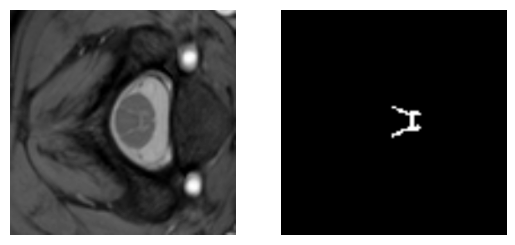

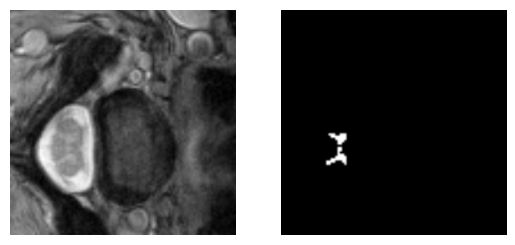

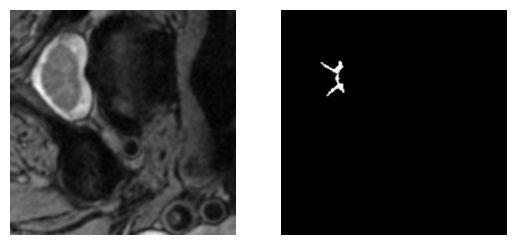

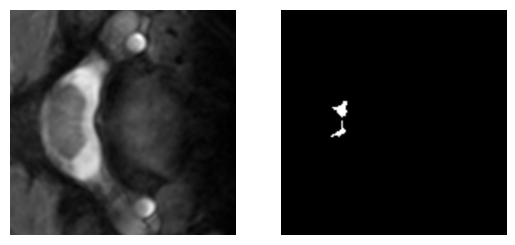

In [39]:
index1=np.random.randint(0,10)
index2=np.random.randint(10,20)
index3=np.random.randint(20,30)
index4=np.random.randint(30,40)
plt.figure()
plot_sample(index1)
plt.figure()
plot_sample(index2)
plt.figure()
plot_sample(index3)
plt.figure()
plot_sample(index4)

In [40]:
for file in os.scandir('./data_formated/masks_slices/'):
    img = np.load(file.path)
    if np.array_equal(img, np.zeros((256,256))):
        print(f'Bad mask, file {file.path}')

In [41]:
class SpinalCordDataset(Dataset):
    def __init__(self, irm_slices_path, mask_slices_path, transform = None):
        self.irm_slices_path = irm_slices_path
        self.mask_slices_path = mask_slices_path
        self.transform = transform

        self.irm_files = [f for f in os.listdir(irm_slices_path) if f.startswith("IRM") and f.endswith(".npy")]
        self.data_pairs = []
        for irm_file in self.irm_files:
            mask_file = 'Mask' + irm_file[3:]
            self.data_pairs.append((irm_file, mask_file))

    def __len__(self):
        return len(self.data_pairs)

    def __getitem__(self, idx):
        irm_file, mask_file = self.data_pairs[idx]
        irm_path = os.path.join(self.irm_slices_path, irm_file)
        mask_path = os.path.join(self.mask_slices_path, mask_file)

        irm = np.load(irm_path)
        mask = np.load(mask_path)

        irm = (irm - irm.min()) / (irm.max() - irm.min())
        irm_uint8 = (irm * 255).astype(np.uint8)

        if self.transform:
            augmented = self.transform(image=irm_uint8, mask=mask)
            irm_tensor = augmented['image']
            mask_tensor = augmented['mask']
        else:
            irm_tensor = torch.from_numpy(irm).float().unsqueeze(0)
            mask_tensor = torch.from_numpy(mask).long()

        return irm_tensor, mask_tensor

In [42]:
# from google.colab import drive
# drive.mount('/content/drive')

In [47]:
# irm_slices_path = '/content/drive/MyDrive/Colab Notebooks/data_formated/MRI_slices'
# mask_slices_path =  '/content/drive/MyDrive/Colab Notebooks/data_formated/masks_slices'

irm_slices_path = 'data_formated/MRI_slices'
mask_slices_path =  'data_formated/masks_slices'

transform = augm.Compose([
    augm.CLAHE(clip_limit=4.0, tile_grid_size=(8,8), p=0.3),
    augm.GaussNoise(var_limit=(10.0, 50.0), p=0.3),
    augm.RandomRotate90(p=0.25),
    augm.Normalize(mean=[0.5], std=[0.5]),
    ToTensorV2()
])

dataset = SpinalCordDataset(irm_slices_path, mask_slices_path, transform)

torch.Size([1, 256, 256]) torch.Size([256, 256])


(-0.5, 255.5, 255.5, -0.5)

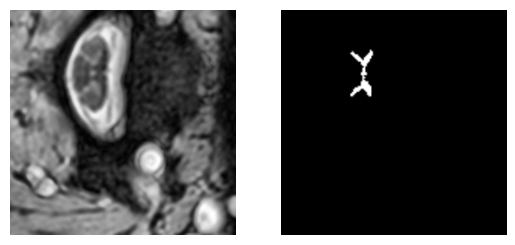

In [49]:
irm_tensor, mask_tensor = dataset[125]
print(irm_tensor.shape, mask_tensor.shape)

plt.subplot(1,2,1)
plt.imshow(irm_tensor[0,:,:], cmap='gray')
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(mask_tensor, cmap='gray')
plt.axis('off')

In [50]:
from sklearn.model_selection import train_test_split

dataset_train, dataset_test_tmp = train_test_split(dataset, test_size=0.15, random_state=11)
dataset_test, dataset_val = train_test_split(dataset_test_tmp, test_size=0.5, random_state=11)

In [51]:
dataloader_train = DataLoader(dataset_train, batch_size=4, shuffle=True)
dataloader_test = DataLoader(dataset_test, batch_size=2, shuffle=True)
dataloader_val = DataLoader(dataset_val, batch_size=2, shuffle=True)

In [52]:
class bloc_convo(nn.Module):
    def __init__(self, input_size, hidden_size = 64, output_size = 64, bool_first_block = False):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.bool_first_block = bool_first_block

        self.activation = nn.ReLU()

        self.dropout = nn.Dropout(0.5)

        self.MaxPooling = nn.MaxPool2d(kernel_size = (2,2))

        self.CNN1 = nn.Conv2d(
            in_channels = self.input_size,
            out_channels = self.hidden_size,
            kernel_size = (3,3),
            padding =(1,1))

        self.CNN2 = nn.Conv2d(
            in_channels = self.hidden_size,
            out_channels = self.output_size,
            kernel_size = (3,3),
            padding =(1,1))

    def forward(self, x):
        if not self.bool_first_block:
            x = self.MaxPooling(x)
        x = self.CNN1(x)
        x = self.activation(x)
        x = self.CNN2(x)
        x = self.activation(x)
        x = self.dropout(x)
        return x

In [53]:
class bloc_deconvo(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, bool_last_block = False):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.bool_last_block = bool_last_block

        self.activation = nn.ReLU()

        self.dropout = nn.Dropout(0.5)

        self.Deconvo1 = nn.ConvTranspose2d(
                in_channels = self.input_size,
                out_channels = self.hidden_size,
                kernel_size = (2,2),
                stride=2)

        self.CNN1 = nn.Conv2d(
            in_channels = 2 * self.hidden_size,
            out_channels = self.hidden_size,
            kernel_size = (3,3),
            padding =(1,1))

        self.CNN2 = nn.Conv2d(
            in_channels = self.hidden_size,
            out_channels = self.output_size,
            kernel_size = (3,3),
            padding =(1,1))

        self.CNN3 = nn.Conv2d(
            in_channels = self.hidden_size,
            out_channels = 1,
            kernel_size = (1,1))


    def forward(self, x, skip_connection):

        # if x.size()[2:] != skip_connection.size()[2:]:  
        #     skip_connection = nn.functional.interpolate(skip_connection, size=x.size()[2:], mode='bilinear', align_corners=True)

        x = self.Deconvo1(x)
        x = torch.concat([x, skip_connection], dim=1)
        x = self.CNN1(x)
        x = self.activation(x)
        x = self.CNN2(x)
        x = self.activation(x)
        x = self.dropout(x)
        if self.bool_last_block:
            x = self.CNN3(x)

        return x

In [54]:
class U_net_model(nn.Module):
    def __init__(self):
        super().__init__()

        self.bloc_convo1 = bloc_convo(input_size=1, hidden_size=64, output_size=64, bool_first_block=True)
        self.bloc_convo2 = bloc_convo(input_size=64, hidden_size=128, output_size=128)
        self.bloc_convo3 = bloc_convo(input_size=128, hidden_size=256, output_size=256)
        self.bloc_convo4 = bloc_convo(input_size=256, hidden_size=512, output_size=512)

        self.bloc_deconvo1 = bloc_deconvo(input_size=512, hidden_size=256, output_size=256)
        self.bloc_deconvo2 = bloc_deconvo(input_size=256, hidden_size=128, output_size=128)
        self.bloc_deconvo3 = bloc_deconvo(input_size=128, hidden_size=64, output_size=64, bool_last_block=True)

    def forward(self, x):
        skip_connection1 = self.bloc_convo1.forward(x)
        skip_connection2 = self.bloc_convo2.forward(skip_connection1)
        skip_connection3 = self.bloc_convo3.forward(skip_connection2)
        x = self.bloc_convo4.forward(skip_connection3)
        x = self.bloc_deconvo1.forward(x, skip_connection3)
        x = self.bloc_deconvo2.forward(x, skip_connection2)
        x = self.bloc_deconvo3.forward(x, skip_connection1)
        return x

In [55]:
class IoU_loss(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, prediction, actual_mask):
        pred_flat = torch.flatten(prediction)
        mask_flat = torch.flatten(actual_mask)

        intersection = torch.sum(pred_flat * mask_flat)
        union = torch.sum(pred_flat + mask_flat) - intersection

        return 1 - ((intersection + 1e-6 )/ (union + 1e-6))

In [56]:
def compute_iou(pred_mask, true_mask):
    intersection = torch.sum(pred_mask * true_mask)
    union = torch.sum(pred_mask) + torch.sum(true_mask) - intersection
    return (intersection + 1e-6) / (union + 1e-6)

In [57]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model = U_net_model()
model.to(device)

cpu


U_net_model(
  (bloc_convo1): bloc_convo(
    (activation): ReLU()
    (dropout): Dropout(p=0.5, inplace=False)
    (MaxPooling): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (CNN1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (CNN2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (bloc_convo2): bloc_convo(
    (activation): ReLU()
    (dropout): Dropout(p=0.5, inplace=False)
    (MaxPooling): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (CNN1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (CNN2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (bloc_convo3): bloc_convo(
    (activation): ReLU()
    (dropout): Dropout(p=0.5, inplace=False)
    (MaxPooling): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (CNN1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1,

In [58]:
class CombinedLoss(nn.Module):
    def __init__(self, pos_weight=None):
        super().__init__()
        if pos_weight is not None:
            self.bce = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
        else:
            self.bce = nn.BCEWithLogitsLoss()

    def forward(self, prediction, actual_mask):
        if len(actual_mask.shape) == len(prediction.shape) - 1:
            actual_mask = actual_mask.unsqueeze(1)
        bce_loss = self.bce(prediction, actual_mask)

        pred_flat = torch.flatten(torch.sigmoid(prediction))
        mask_flat = torch.flatten(actual_mask)

        intersection = torch.sum(pred_flat * mask_flat)
        union = torch.sum(pred_flat + mask_flat) - intersection
        iou_loss = 1 - ((intersection + 1e-6) / (union + 1e-6))

        return bce_loss + iou_loss

def compute_pos_weight(dataloader):
    total_positives = 0
    total_negatives = 0

    for images, masks in dataloader:
        total_positives += torch.sum(masks == 1).item()
        total_negatives += torch.sum(masks == 0).item()

    pos_weight_value = total_negatives / (total_positives + 1e-6)
    pos_weight = torch.tensor([pos_weight_value], device=device)

    return pos_weight

In [59]:
def erode_masks(output_probs, kernel_size=3, iterations=2, threshold=0.5):
    kernel = np.ones((kernel_size, kernel_size), np.uint8)
    eroded_masks = []

    for i in range(output_probs.shape[0]):
        pred = (output_probs[i, 0].cpu().numpy() > threshold).astype(np.uint8) * 255
        eroded = cv2.erode(pred, kernel, iterations=iterations)
        eroded_masks.append(eroded.astype(np.float32) / 255)
    eroded_masks_tensor = torch.tensor(np.array(eroded_masks)).unsqueeze(1).to(output_probs.device)
    return eroded_masks_tensor

In [60]:
def train_model(model, train_dataloader, val_dataloader, epochs):
    train_losses = []
    val_losses = []
    train_ious = []
    val_ious = []
    train_ious_er1 = []
    val_ious_er1 = []
    train_ious_er2 = []
    val_ious_er2 = []
    train_ious_er3 = []
    val_ious_er3 = []

    pos_weight = compute_pos_weight(train_dataloader)
    criterion = CombinedLoss(pos_weight=pos_weight)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

    best_val_loss = float("inf")
    best_model = None

    for epoch in range(epochs):
        tr_losses_epoch = []
        tr_iou_epoch = []
        val_losses_epoch = []
        val_iou_epoch = []
        tr_ious_er1_epoch = []
        val_ious_er1_epoch = []
        tr_ious_er2_epoch = []
        val_ious_er2_epoch = []
        tr_ious_er3_epoch = []
        val_ious_er3_epoch = []

        model = model.train()
        for batch in train_dataloader:
            optimizer.zero_grad()
            images, masks = batch
            images, masks = images.to(device), masks.to(device)
            pred = model(images)
            loss = criterion(pred, masks)
            tr_losses_epoch.append(loss.item())

            pred_mask = (torch.sigmoid(pred) > 0.5).float()
            iou = compute_iou(pred_mask, masks)
            tr_iou_epoch.append(iou.item())

            erod_masks1 = erode_masks(pred_mask, iterations=1)
            iou_er1 = compute_iou(erod_masks1, masks)
            tr_ious_er1_epoch.append(iou_er1.item())

            erod_masks2 = erode_masks(pred_mask, iterations=2)
            iou_er2 = compute_iou(erod_masks2, masks)
            tr_ious_er2_epoch.append(iou_er2.item())

            erod_masks3 = erode_masks(pred_mask, iterations=3)
            iou_er3 = compute_iou(erod_masks3, masks)
            tr_ious_er3_epoch.append(iou_er3.item())

            loss.backward()
            optimizer.step()

        model = model.eval()
        with torch.no_grad():
            for batch_val in val_dataloader:
                image_val = batch_val[0].to(device)
                mask_val = batch_val[1].to(device)
                pred_val = model.forward(image_val)
                loss_val = criterion(pred_val, mask_val)
                val_losses_epoch.append(loss_val.item())

                pred_val_mask = (torch.sigmoid(pred_val) > 0.5).float()

                val_iou = compute_iou(pred_val_mask, mask_val)
                val_iou_epoch.append(val_iou.item())

                erod_masks1_val = erode_masks(pred_val_mask, iterations=1)
                iou_er1_val = compute_iou(erod_masks1_val, mask_val)
                val_ious_er1_epoch.append(iou_er1_val.item())

                erod_masks2_val = erode_masks(pred_val_mask, iterations=2)
                iou_er2_val = compute_iou(erod_masks2_val, mask_val)
                val_ious_er2_epoch.append(iou_er2_val.item())

                erod_masks3_val = erode_masks(pred_val_mask, iterations=3)
                iou_er3_val = compute_iou(erod_masks3_val, mask_val)
                val_ious_er3_epoch.append(iou_er3_val.item())

        train_losses.append(np.mean(tr_losses_epoch))
        val_losses.append(np.mean(val_losses_epoch))
        train_ious.append(np.mean(tr_iou_epoch))
        val_ious.append(np.mean(val_iou_epoch))
        train_ious_er1.append(np.mean(tr_ious_er1_epoch))
        train_ious_er2.append(np.mean(tr_ious_er2_epoch))
        train_ious_er3.append(np.mean(tr_ious_er3_epoch))
        val_ious_er1.append(np.mean(val_ious_er1_epoch))
        val_ious_er2.append(np.mean(val_ious_er2_epoch))
        val_ious_er3.append(np.mean(val_ious_er3_epoch))

        if np.mean(val_losses_epoch) < best_val_loss:
            best_val_loss = np.mean(val_losses_epoch)
            best_model = model.state_dict()
            torch.save(best_model, 'model.pth')

        print(f'Epoch {epoch+1}/{epochs} : '
              f'Train loss = {np.mean(tr_losses_epoch):.4f} // '
              f'Val loss = {np.mean(val_losses_epoch):.4f} // '
              f'Train IoU = {np.mean(tr_iou_epoch):.4f} // '
              f'Val IoU = {np.mean(val_iou_epoch):.4f}')

    return model, train_losses, val_losses, train_ious, val_ious, train_ious_er1, val_ious_er1, train_ious_er2, val_ious_er2, train_ious_er3, val_ious_er3


In [61]:
# model, train_losses, val_losses, train_ious, val_ious, train_ious_er1, val_ious_er1, train_ious_er2, val_ious_er2, train_ious_er3, val_ious_er3 = train_model(model, dataloader_train, dataloader_val, epochs=150)

In [63]:
# from google.colab import files

# with open('ero0_train.json','w') as f0:
#   json.dump(train_ious,f0)
# with open('ero1_train.json', 'w') as f1:
#   json.dump(train_ious_er1, f1)
# with open('ero2_train.json', 'w') as f2:
#   json.dump(train_ious_er2, f2)
# with open('ero3_train.json', 'w') as f3:
#   json.dump(train_ious_er3, f3)
# with open('ero0_val.json','w') as f0:
#   json.dump(val_ious,f0)
# with open('ero1_val.json', 'w') as f1:
#   json.dump(val_ious_er1, f1)
# with open('ero2_val.json', 'w') as f2:
#   json.dump(val_ious_er2, f2)
# with open('ero3_val.json', 'w') as f3:
#   json.dump(val_ious_er3, f3)
# files.download('ero0_train.json')
# files.download('ero1_train.json')
# files.download('ero2_train.json')
# files.download('ero3_train.json')
# files.download('ero0_val.json')
# files.download('ero1_val.json')
# files.download('ero2_val.json')
# files.download('ero3_val.json')

# with open('loss_train.json','w') as f0:
#   json.dump(train_losses,f0)
# with open('loss_val.json', 'w') as f1:
#   json.dump(val_losses, f1)
# files.download('loss_train.json')
# files.download('loss_val.json')

# torch.save(model, 'model_final.pth')
# files.download('model_final.pth')

In [69]:
json_files = ['ero0_train.json', 'ero1_train.json', 'ero2_train.json', 'ero3_train.json', 
                'ero0_val.json', 'ero1_val.json', 'ero2_val.json', 'ero3_val.json',
                'loss_train.json', 'loss_val.json']

json_data = {}

for file in json_files:
    with open('training_results/' + file, 'r') as f:
        json_data[file] = json.load(f)

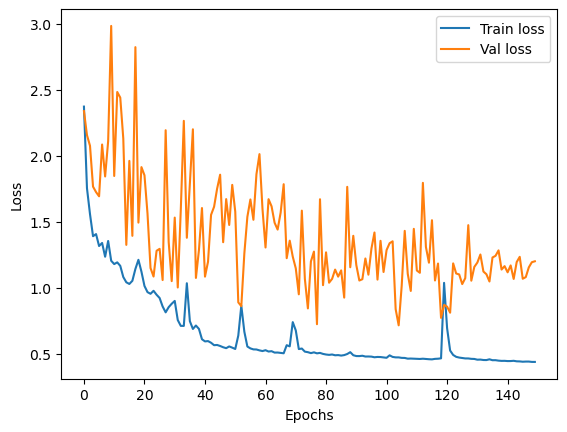

In [70]:
plt.plot(json_data['loss_train.json'], label='Train loss')
plt.plot(json_data['loss_val.json'], label='Val loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

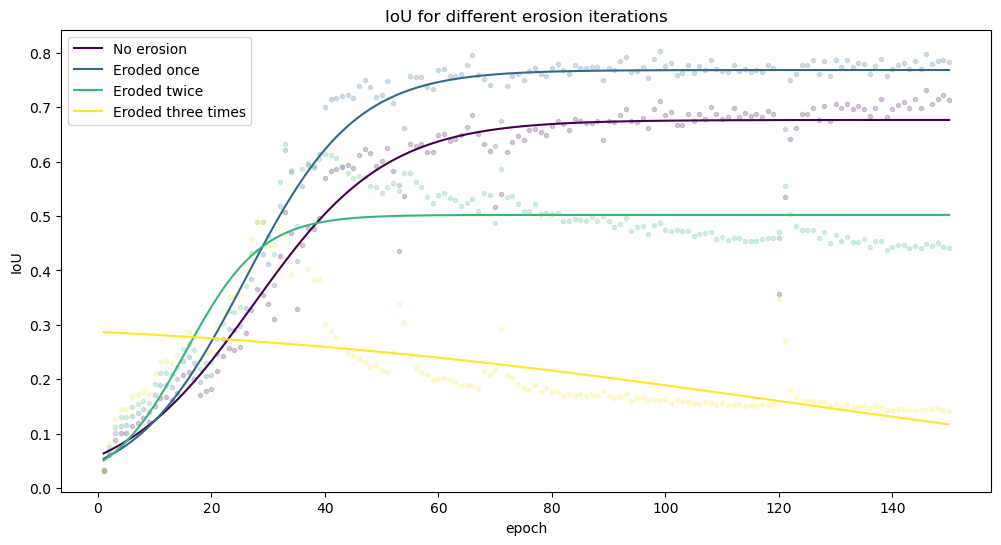

In [116]:
def logistic_reg(x, L, x0, k):
    return L / (1 + np.exp(-k * (x - x0)))

x = range(1, 151)

y_lists = [
    json_data['ero0_train.json'],  
    json_data['ero1_train.json'],  
    json_data['ero2_train.json'],
    json_data['ero3_train.json']
]

labels_list = ['No erosion', 'Eroded once', 'Eroded twice', 'Eroded three times']
colormap = plt.cm.viridis
colors = colormap(np.linspace(0, 1, len(y_lists)))

plt.figure(figsize=(12, 6))

for i, y in enumerate(y_lists):
    params, _ = curve_fit(logistic_reg, x, y, p0=[1, np.median(x), 1], maxfev=2000)
    L, x0, k = params
    plt.scatter(x, y, color=colors[i], alpha=0.2, marker='.')

    plt.plot(x, logistic_reg(x, L, x0, k), label=labels_list[i], color=colors[i])
plt.legend()
plt.xlabel('epoch')
plt.ylabel('IoU')
plt.title('IoU for different erosion iterations')
plt.show()

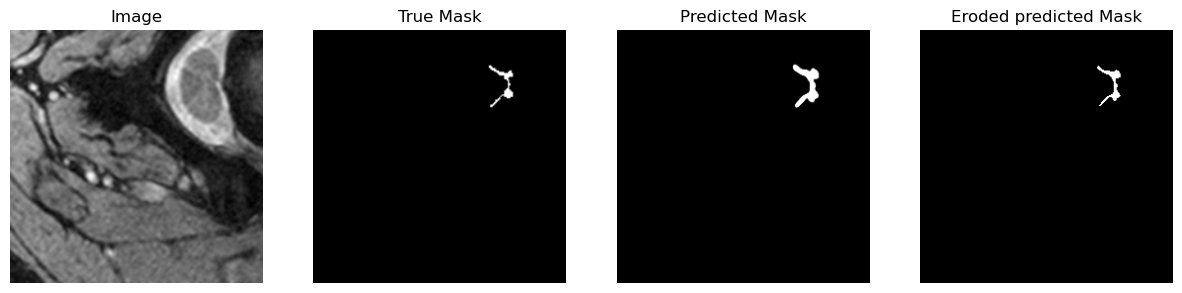

In [120]:
with torch.no_grad():
    for batch in dataloader_test:
        images, masks = batch
        images, masks = images.to(device), masks.to(device)

        outputs = model(images)

        output_probs = torch.sigmoid(outputs)
        erod_masks1 = erode_masks(output_probs, iterations=1)
        
        fig, ax = plt.subplots(1, 4, figsize=(15, 5))
        ax[0].imshow(images[0].cpu().numpy().transpose(1, 2, 0), cmap='gray')
        ax[0].set_title('Image')
        ax[0].axis('off')

        ax[1].imshow(masks[0].cpu().numpy(), cmap='gray')
        ax[1].set_title('True Mask')
        ax[1].axis('off')

        ax[2].imshow(output_probs[0][0].cpu().numpy(), cmap='gray')
        ax[2].set_title('Predicted Mask')
        ax[2].axis('off')

        ax[3].imshow(erod_masks1[0][0].cpu().numpy(), cmap='gray') 
        ax[3].set_title('Eroded predicted Mask')
        ax[3].axis('off')
        
        plt.show()


        break

In [114]:
model = torch.load('model_final.pth', map_location=torch.device('cpu'))

/tmp/ipykernel_2958/314791820.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load('model_final.pth', map_location=torch.device('cpu'))
